## Use Random Forest to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"


The steps include data loading, preprocessing, exploratory data analysis, model training, and evaluation.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the dataset from Google Drive
# Ensure the path is correct and accessible
data_path = 'Fraud_check.csv'
fraud_data = pd.read_csv(data_path)
fraud_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [4]:
# Checking for missing values and basic statistics
# This helps in understanding the data quality
print(fraud_data.isnull().sum())
print(fraud_data.describe())

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64
       Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000


In [5]:
# Checking for missing values and basic statistics
# This helps in understanding the data quality
print(fraud_data.isnull().sum())
print(fraud_data.describe())

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64
       Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000


In [6]:
# Feature Engineering: Categorizing 'Taxable.Income'
# Creating a new column 'Income.Category' based on income thresholds
fraud_data['Income.Category'] = pd.cut(fraud_data['Taxable.Income'], bins=[10002, 30000, 99620], labels=['Risky', 'Good'])
fraud_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Income.Category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


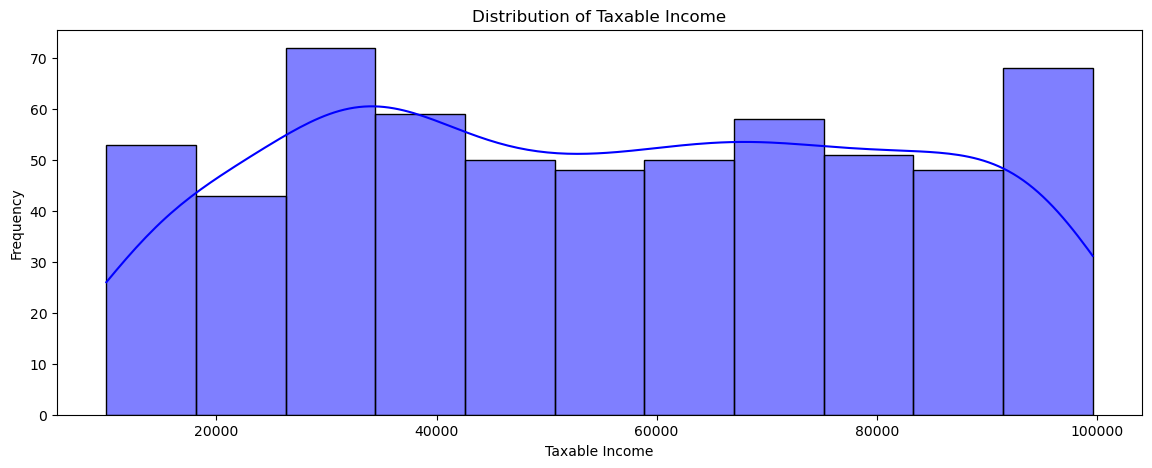

In [7]:
# Exploratory Data Analysis: Visualizing the distribution of 'Taxable.Income'
# This helps in understanding the data distribution
plt.figure(figsize=(14, 5))
sns.histplot(fraud_data['Taxable.Income'], color="blue", kde=True)
plt.title('Distribution of Taxable Income')
plt.xlabel('Taxable Income')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Checking the distribution of the new 'Income.Category'
# This helps in understanding the class balance
print(fraud_data['Income.Category'].value_counts())

Income.Category
Good     476
Risky    124
Name: count, dtype: int64


In [9]:
# Identifying categorical and numerical features
# This is important for preprocessing steps
categorical_cols = fraud_data.select_dtypes(include=['object']).columns
numerical_cols = fraud_data.select_dtypes(include=['int64', 'float64']).columns
print("Categorical Features:", categorical_cols)
print("Numerical Features:", numerical_cols)

Categorical Features: Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')
Numerical Features: Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')


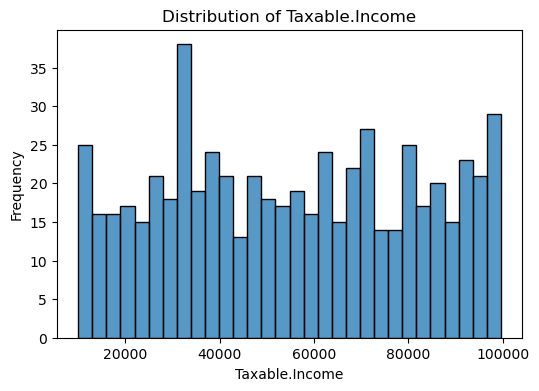

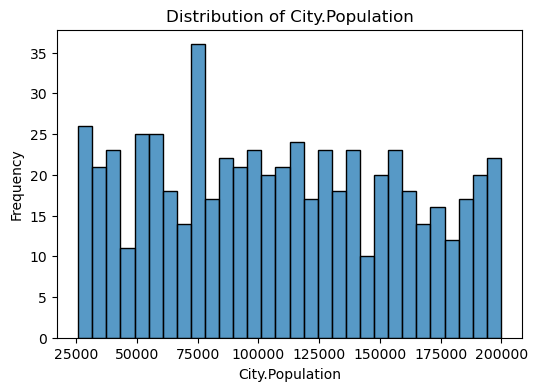

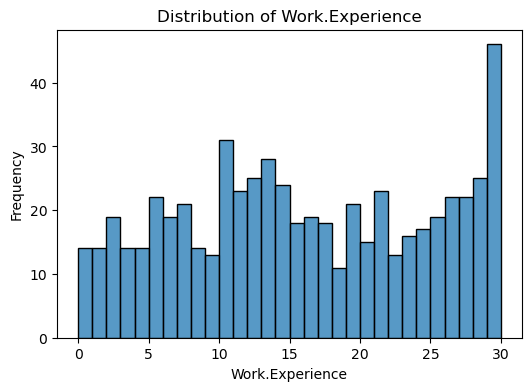

In [10]:
# Visualizing numerical features to check for skewness
# Skewness can affect model performance
for feature in numerical_cols:
  plt.figure(figsize=(6, 4))
  sns.histplot(fraud_data[feature], kde=False, bins=30)
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

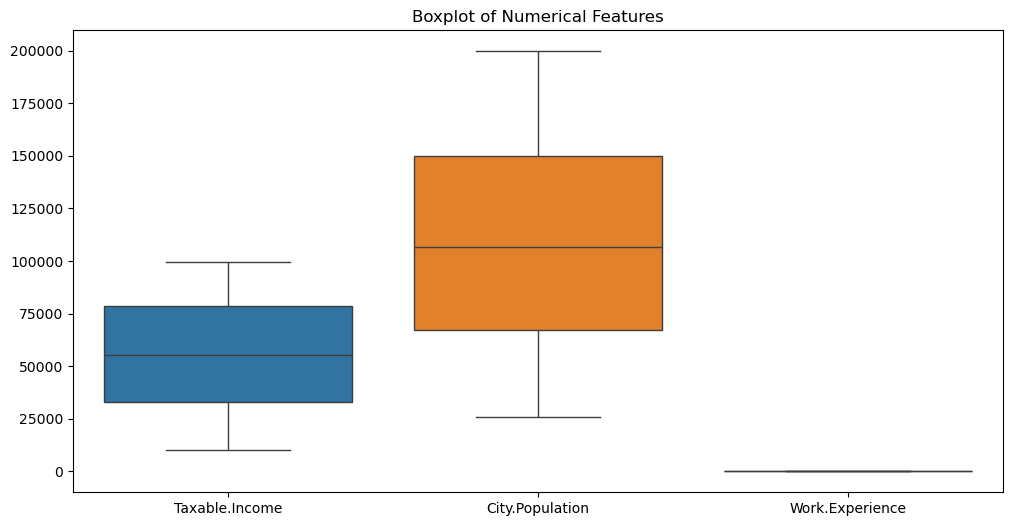

In [11]:
# Checking for outliers using boxplots
# Outliers can affect model performance
plt.figure(figsize=(12, 6))
sns.boxplot(data=fraud_data[numerical_cols])
plt.title('Boxplot of Numerical Features')
plt.show()

In [12]:
# Encoding categorical features using Label Encoding
# This is necessary for machine learning models
label_encoder = LabelEncoder()
for col in categorical_cols:
  fraud_data[col] = label_encoder.fit_transform(fraud_data[col])
fraud_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Income.Category
0,0,2,68833,50047,10,1,Good
1,1,0,33700,134075,18,1,Good
2,0,1,36925,160205,30,1,Good
3,1,2,50190,193264,15,1,Good
4,0,1,81002,27533,28,0,Good


In [13]:
# Splitting the data into features and target variable
# This is necessary for model training
X = fraud_data.drop(['Taxable.Income', 'Income.Category'], axis=1)
y = fraud_data['Income.Category']

In [14]:
# Feature selection using SelectKBest
# This helps in selecting the most important features
selector = SelectKBest(score_func=chi2, k=4)
X_selected = selector.fit_transform(X, y)
print("Selected Features:", X.columns[selector.get_support()])

Selected Features: Index(['Undergrad', 'Marital.Status', 'City.Population', 'Work.Experience'], dtype='object')


In [15]:
# Splitting the data into training and testing sets
# This is necessary for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
# Handling class imbalance using SMOTE
# This helps in improving model performance on imbalanced data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_sm))

Class distribution after SMOTE: Counter({'Good': 333, 'Risky': 333})


In [17]:
# Training a Random Forest Classifier
# Random Forest is a robust model for classification tasks
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

In [18]:
# Evaluating the model on the test set
# This helps in understanding the model's performance
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6333333333333333
Classification Report:
               precision    recall  f1-score   support

        Good       0.80      0.72      0.76       143
       Risky       0.22      0.30      0.25        37

    accuracy                           0.63       180
   macro avg       0.51      0.51      0.50       180
weighted avg       0.68      0.63      0.65       180



In [19]:
# Saving the trained model using pickle
# This allows for model deployment and future use
from pickle import dump
dump(rf_model, open('fraud_detection_model.pkl', 'wb'))